# Image Segmentation using Segmenter
---
## Instructions
- In this assignment, we will perform semantic segmentation on PASCAL VOC 2011 dataset which contains 20 object categories. We use the Semantic Boundaries Dataset (SBD) as it contains more segmentation labels than the original dataset.
- To this end, you need to implement necessary network components, load and fine-tune the pretrained network, and report segmentation performance on the validation set.

---
## Prerequisite: Setup the `root` directory properly.

In [1]:
# Specify the directory path where `Segmentation.ipynb` exists.
# For example, if you saved `Segmentation.ipynb` in `/drive/Segmentation` directory,
# then set root = '/drive/Segmentation'
root = './'

---
# Basic settings

## Import libraries

In [2]:
import os
import time
import traceback
import logging
from easydict import EasyDict as edict
import numpy as np
from pathlib import Path
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import VOCSegmentation, SBDataset
from torchvision.datasets.vision import StandardTransform
# from torchvision.models.vgg import VGG, vgg16, make_layers

torch.backends.cudnn.benchmark = True
torch.use_deterministic_algorithms(True, warn_only=True)

!pip install git+https://github.com/lucasb-eyer/pydensecrf.git
import pydensecrf.densecrf as dcrf
import pydensecrf.utils as utils

!pip install einops
from einops import rearrange, reduce, repeat

!pip install timm==0.9.12
from timm.models.vision_transformer import vit_tiny_patch16_224, vit_tiny_patch16_384

  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-67b6lc_6
  Running command git clone --filter=blob:none --quiet https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-67b6lc_6
  Resolved https://github.com/lucasb-eyer/pydensecrf.git to commit 2723c7fa4f2ead16ae1ce3d8afe977724bb8f87f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Hyperparameters

In [20]:
# Basic settings
torch.manual_seed(42)
torch.cuda.manual_seed(42)

args = edict()
args.batch_size = 1
args.lr = 1e-4
args.momentum = 0.9
args.weight_decay = 5e-4
args.epoch = 6
args.tensorboard = True
args.gpu = True

device = 'cuda' if torch.cuda.is_available() and args.gpu else 'cpu'

# Create directory name.
result_dir = Path(root) / 'results'
result_dir.mkdir(parents=True, exist_ok=True)

## Tensorboard

In [ ]:
# Setup tensorboard.
if args.tensorboard:
    %reload_ext tensorboard
    %tensorboard --logdir result_dir --samples_per_plugin images=100
else:
    writer = None

---
# Utility functions

Here are some utility functions that we will use throughout this assignment. You don't have to modify any of these.  
**Conditional Random Field (CRF)** is a technique to further improve segmentation performance, mainly focusing on better localization. Details can be found in the [DeepLab](https://arxiv.org/abs/1606.00915) paper.

In [5]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        trunc_normal_(m.weight, std=0.02)
        if isinstance(m, nn.Linear) and m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.LayerNorm):
        nn.init.constant_(m.bias, 0)
        nn.init.constant_(m.weight, 1.0)


class toLongTensor:
    """ Convert a byte tensor to a long tensor """
    def __call__(self, img):
        output = torch.from_numpy(np.array(img).astype(np.int32)).long()
        output[output == 255] = 21
        return output


def _fast_hist(label_true, label_pred, n_class):
    mask = (label_true >= 0) & (label_true < n_class)
    hist = np.bincount(
        n_class * label_true[mask].astype(int) +
        label_pred[mask], minlength=n_class ** 2).reshape(n_class, n_class)
    return hist


def label_accuracy_score(label_trues, label_preds, n_class):
    """ Returns overall accuracy and mean IoU """
    hist = np.zeros((n_class, n_class))
    for lt, lp in zip(label_trues, label_preds):
        hist += _fast_hist(lt.flatten(), lp.flatten(), n_class)
    acc = np.diag(hist).sum() / hist.sum()
    with np.errstate(divide='ignore', invalid='ignore'):
        iou = np.diag(hist) / (
            hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist)
        )
    mean_iou = np.nanmean(iou)
    return acc, mean_iou


class Colorize(object):
    """ Colorize the segmentation labels """
    def __init__(self, n=35, cmap=None):
        if cmap is None:
            raise NotImplementedError()
            self.cmap = labelcolormap(n)
        else:
            self.cmap = cmap
        self.cmap = self.cmap[:n]

    def preprocess(self, x):
        if len(x.size()) > 3 and x.size(1) > 1:
            # if x has a shape of [B, C, H, W],
            # where B and C denote a batch size and the number of semantic classe
            # then translate it into a shape of [B, 1, H, W]
            x = x.argmax(dim=1, keepdim=True).float()
        assert (len(x.shape) == 4) and (x.size(1) == 1), 'x should have a shape of [B, 1, H, W]'
        return x

    def __call__(self, x):
        x = self.preprocess(x)
        if (x.dtype == torch.float) and (x.max() < 2):
            x = x.mul(255).long()
        color_images = []
        gray_image_shape = x.shape[1:]
        for gray_image in x:
            color_image = torch.ByteTensor(3, *gray_image_shape[1:]).fill_(0)
            for label, cmap in enumerate(self.cmap):
                mask = (label == gray_image[0]).cpu()
                color_image[0][mask] = cmap[0]
                color_image[1][mask] = cmap[1]
                color_image[2][mask] = cmap[2]
            color_images.append(color_image)
        color_images = torch.stack(color_images)
        return color_images


def uint82bin(n, count=8):
    """ Returns the binary of integer n, count refers to amount of bits """
    return ''.join([str((n >> y) & 1) for y in range(count-1, -1, -1)])


def get_color_map():
    """ Returns N color map """
    N=25
    color_map = np.zeros((N, 3), dtype=np.uint8)
    for i in range(N):
        r, g, b = 0, 0, 0
        id = i
        for j in range(7):
            str_id = uint82bin(id)
            r = r ^ (np.uint8(str_id[-1]) << (7-j))
            g = g ^ (np.uint8(str_id[-2]) << (7-j))
            b = b ^ (np.uint8(str_id[-3]) << (7-j))
            id = id >> 3
        color_map[i, 0] = r
        color_map[i, 1] = g
        color_map[i, 2] = b
    color_map = torch.from_numpy(color_map)
    return color_map


def dense_crf(img, output_probs):
    """ Conditional Random Field for better segmentation
        Refer to https://github.com/lucasb-eyer/pydensecrf for details.
    """
    c = output_probs.shape[0]
    h = output_probs.shape[1]
    w = output_probs.shape[2]

    U = utils.unary_from_softmax(output_probs)
    U = np.ascontiguousarray(U)

    img = np.ascontiguousarray(img)

    d = dcrf.DenseCRF2D(w, h, c)
    d.setUnaryEnergy(U)
    d.addPairwiseGaussian(sxy=1, compat=3)
    d.addPairwiseBilateral(sxy=67, srgb=3, rgbim=img, compat=4)

    Q = d.inference(10)
    Q = np.array(Q).reshape((c, h, w))
    return Q


def add_padding(img):
    """ Zero-pad image(or any array-like object) to 500x500. """
    w, h = img.shape[-2], img.shape[-1]
    MAX_SIZE = w + 36
    IGNORE_IDX = 21

    assert max(w, h) <= MAX_SIZE, f'both height and width should be less than {MAX_SIZE}'

    _pad_left = (MAX_SIZE - w) // 2
    _pad_right = (MAX_SIZE - w + 1) // 2
    _pad_up = (MAX_SIZE - h) // 2
    _pad_down = (MAX_SIZE - h + 1) // 2

    _pad = (_pad_up, _pad_down, _pad_left, _pad_right)

    padding_img = transforms.Pad(_pad)
    padding_target = transforms.Pad(_pad, fill=IGNORE_IDX)

    img = F.pad(img, pad=_pad)
    return img

---
# Define `DataLoader` for training & validation set

If the cell below fails with error message "Destination path `./cls` already exists", try again with `download=False`.

In [7]:
mean = [.485, .456, .406]
std = [.229, .224, .225]

# define transform functions.
im_size = 384
transform_train = transforms.Compose([
    transforms.Resize((im_size, im_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
transform_train_target = transforms.Compose([
    transforms.Resize((im_size, im_size), interpolation=transforms.InterpolationMode.NEAREST),
    toLongTensor()
])
transform_test = transforms.Compose([
    transforms.Resize((im_size, im_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
transform_test_target = transforms.Compose([
    transforms.Resize((im_size, im_size), interpolation=transforms.InterpolationMode.NEAREST),
    toLongTensor()
])

# define dataloader.
sbd_transform_train = StandardTransform(transform_train, transform_train_target)
sbd_transform_test = StandardTransform(transform_test, transform_test_target)
try:
    train_dataset = SBDataset(root='.', image_set='train', mode='segmentation', download=True, transforms=sbd_transform_train)
except:
    train_dataset = SBDataset(root='.', image_set='train', mode='segmentation', download=False, transforms=sbd_transform_train)
test_dataset = SBDataset(root='.', image_set='val', mode='segmentation', download=False, transforms=sbd_transform_test)
train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)

Using downloaded and verified file: ./benchmark.tgz
Extracting ./benchmark.tgz to .


---
# Define networks

# Part 1. Implement Attention layer [(Illustration)](https://docs.google.com/drawings/d/1HOI4QoqSACBFCeW0xVTOkn3XINBoEDNbr2xbtb9LZVY)

### (a) Declare q, k, v projection layers.
### (b) Declare output projection layer.
### (c) Declare dropout layers.
### (d) Implement forward method
The `forward` method should
- Map the input to queries, keys, and values.
- Compute the the inner-product between queries and keys
  - Multiply self.scale to the inner-product for stable training
- Compute the attention score by applying the softmax.
- Dropout the attention score
- Aggregate values based on the attention score
- Apply output projection layer
- Apply projection dropout.
- return the output and attention score.

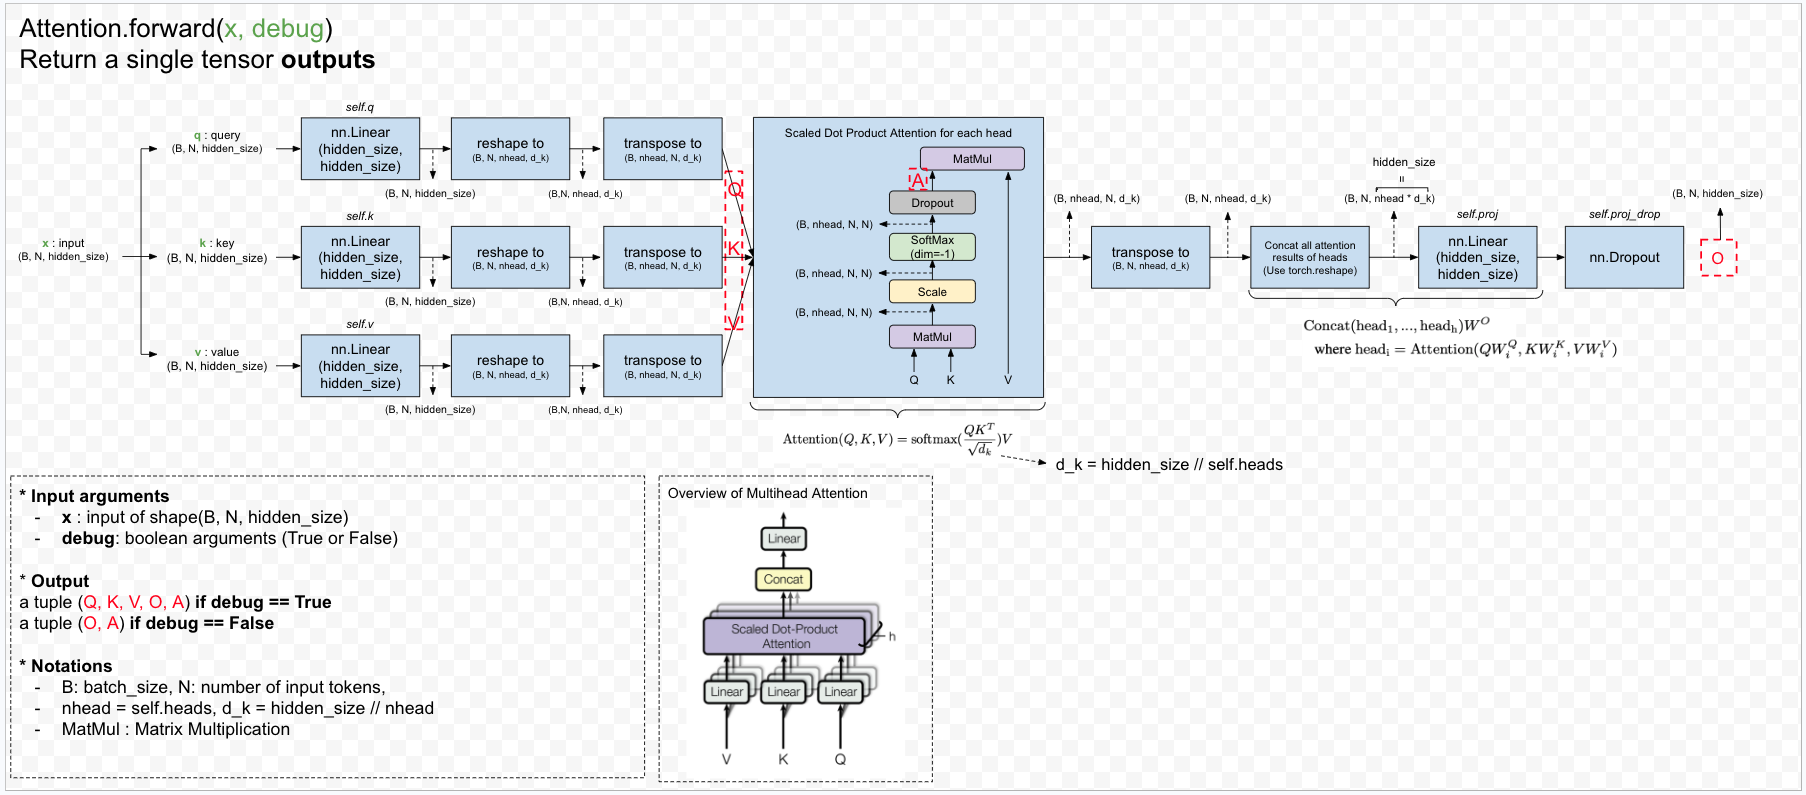

In [8]:
class Attention(nn.Module):
    def __init__(self, hidden_size, heads, dropout):
        super().__init__()
        self.heads = heads
        head_dim = hidden_size // heads
        self.scale = head_dim ** -0.5
        self.attn = None

        ################################################
        # Write your code here
        self.q = nn.Linear(in_features=hidden_size, out_features=hidden_size)
        self.k = nn.Linear(in_features=hidden_size, out_features=hidden_size)
        self.v = nn.Linear(in_features=hidden_size, out_features=hidden_size)
        self.attn_drop = nn.Dropout(p=dropout)
        self.proj = nn.Linear(in_features=hidden_size, out_features=hidden_size)
        self.proj_drop = nn.Dropout(p=dropout)
        ################################################

    def forward(self, x, mask=None, debug=False):
        B, N, C = x.shape
        ################################################
        # Write your code here.
        # Add more lines as you wish.
        q = (self.q(x)).reshape(B, N, self.heads, C // self.heads).permute(0, 2, 1, 3)
        k = (self.k(x)).reshape(B, N, self.heads, C // self.heads).permute(0, 2, 1, 3)
        v = (self.v(x)).reshape(B, N, self.heads, C // self.heads).permute(0, 2, 1, 3)
        
        attn = (q @ k.permute(0, 1, 3, 2)) * self.scale
              # torch.matmul(q, k.permute(0, 1, 3, 2)) * self.scale
        attn = self.attn_drop(F.softmax(attn, dim=-1))

        output = (attn @ v).permute(0, 2, 1, 3).reshape(B, N, C)
              # torch.matmul(attn, v).permute(0, 2, 1, 3).reshape(B, N, C)
        output = self.proj_drop(self.proj(output))

        ################################################

        if debug:
          return q, k, v, output, attn
        else:
          return output, attn

    @property
    def unwrapped(self):
        return self

In [9]:
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout, out_dim=None):
        super().__init__()
        self.fc1 = nn.Linear(dim, hidden_dim)
        self.act = nn.GELU()
        if out_dim is None:
            out_dim = dim
        self.fc2 = nn.Linear(hidden_dim, out_dim)
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

    @property
    def unwrapped(self):
        return self


class Block(nn.Module):
    def __init__(self, dim, heads, mlp_dim, dropout):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.attn = Attention(dim, heads, dropout)
        self.mlp = FeedForward(dim, mlp_dim, dropout)

    def forward(self, x, mask=None, return_attention=False):
        y, attn = self.attn(self.norm1(x), mask)
        if return_attention:
            return attn
        x = x + y
        x = x + self.mlp(self.norm2(x))
        return x

## Attention Layer Tests

This section tests your solution for Attention Loayer. **Please do not modify the code!**

In [10]:
@torch.no_grad()
def run_tests_p1():
    n_pass, n_test = 0, 3
    B, N, C = 2, 10, 192
    try:
        torch.manual_seed(42)
        torch.cuda.manual_seed_all(42)
        net = Attention(C, 3, 0.1)
        print(f"[TEST  1/{n_test} Passed] Attention.__init__ executed without errors")
        n_pass += 1
    except Exception as e:
        print(f"[TEST  1/{n_test} Failed] Attention.__init__ execution error; please see the traceback below")
        print(f"\n{traceback.format_exc()}")

        net = nn.Identity()

    try:
        torch.manual_seed(42)
        torch.cuda.manual_seed_all(42)
        x = torch.randn(B, N, C)
        q, k, v, output, attn = net(x, debug=True)
        print(f"[TEST  2/{n_test} Passed] Attention.forward executed without errors")
        n_pass += 1

    except Exception as e:
        print(f"[TEST  2/{n_test} Failed] Attention.forward execution error;")
        print(f"\n{traceback.format_exc()}")
        return

    try:
        q_shape = k_shape = v_shape = torch.Size([2, 3, 10, 64])
        attn_shape = torch.Size([2, 3, 10, 10])
        output_shape = torch.Size([2, 10, 192])

        not_matches = []
        if q.shape != q_shape:
            not_matches.append('q')
        if k.shape != k_shape:
            not_matches.append('k')
        if v.shape != v_shape:
            not_matches.append('v')
        if attn.shape != attn_shape:
            not_matches.append('attn')
        if output.shape != output_shape:
            not_matches.append('output')
        assert len(not_matches) == 0
        print(f"[TEST  3/{n_test} Passed] Shape of q, k, v, attn, output are matched")
        n_pass += 1
    except Exception as e:
        print(f"[TEST  3/{n_test} Failed] Shape of {not_matches} are not matched")
    '''
    try:
        q_mean, q_std = q.abs().mean(), q.abs().std()
        k_mean, k_std = k.abs().mean(), k.abs().std()
        v_mean, v_std = v.abs().mean(), v.abs().std()
        attn_mean, attn_std = attn.abs().mean(), attn.abs().std()
        output_mean, output_std = output.abs().mean(), output.abs().std()
        not_matches = []
        if ((q_mean - 0.4701).abs() > 1e-4) or ((q_std - 0.3834).abs() > 1e-4):
            not_matches.append('q')
        if ((k_mean - 0.4509).abs() > 1e-4) or ((k_std - 0.3436).abs() > 1e-4):
            not_matches.append('k')
        if ((v_mean - 0.4423).abs() > 1e-4) or ((v_std - 0.3363).abs() > 1e-4):
            not_matches.append('v')
        if ((attn_mean - 0.0999).abs() > 1e-4) or ((attn_std - 0.0498).abs() > 1e-4):
            not_matches.append('attn')
        if ((output_mean - 0.1003).abs() > 1e-4) or ((output_std - 0.0870).abs() > 1e-4):
            not_matches.append('output')
        assert len(not_matches) == 0
        print(f"[TEST  4/{n_test} Passed] All values are matched")
        n_pass += 1
    except Exception as e:
        print(f"[TEST  4/{n_test} Failed] Value of {not_matches} are not matched")
    '''
    if n_pass == n_test:
        print(f"\n[TEST] 🎉🎉🥳 All {n_pass}/{n_test} tests passed!")


run_tests_p1()

[TEST  1/3 Passed] Attention.__init__ executed without errors
[TEST  2/3 Passed] Attention.forward executed without errors
[TEST  3/3 Passed] Shape of q, k, v, attn, output are matched

[TEST] 🎉🎉🥳 All 3/3 tests passed!


# Part 2. Implement MaskTransformer [(Illustration)](https://docs.google.com/drawings/d/1TQ9lDfIimTom7df7_6ThzF9cOnedqIWN0xK8cB_-cSk)

The MaskTransformer takes the output from the ViT encoder to predict the segmentation mask. First, the visual tokens from the ViT encoder are concatenated with class embeddings and sent to the MaskTransformer. The MaskTransformer processes these tokens, and then it calculates the segmentation mask by computing the inner product between the class embeddings and the visual tokens.

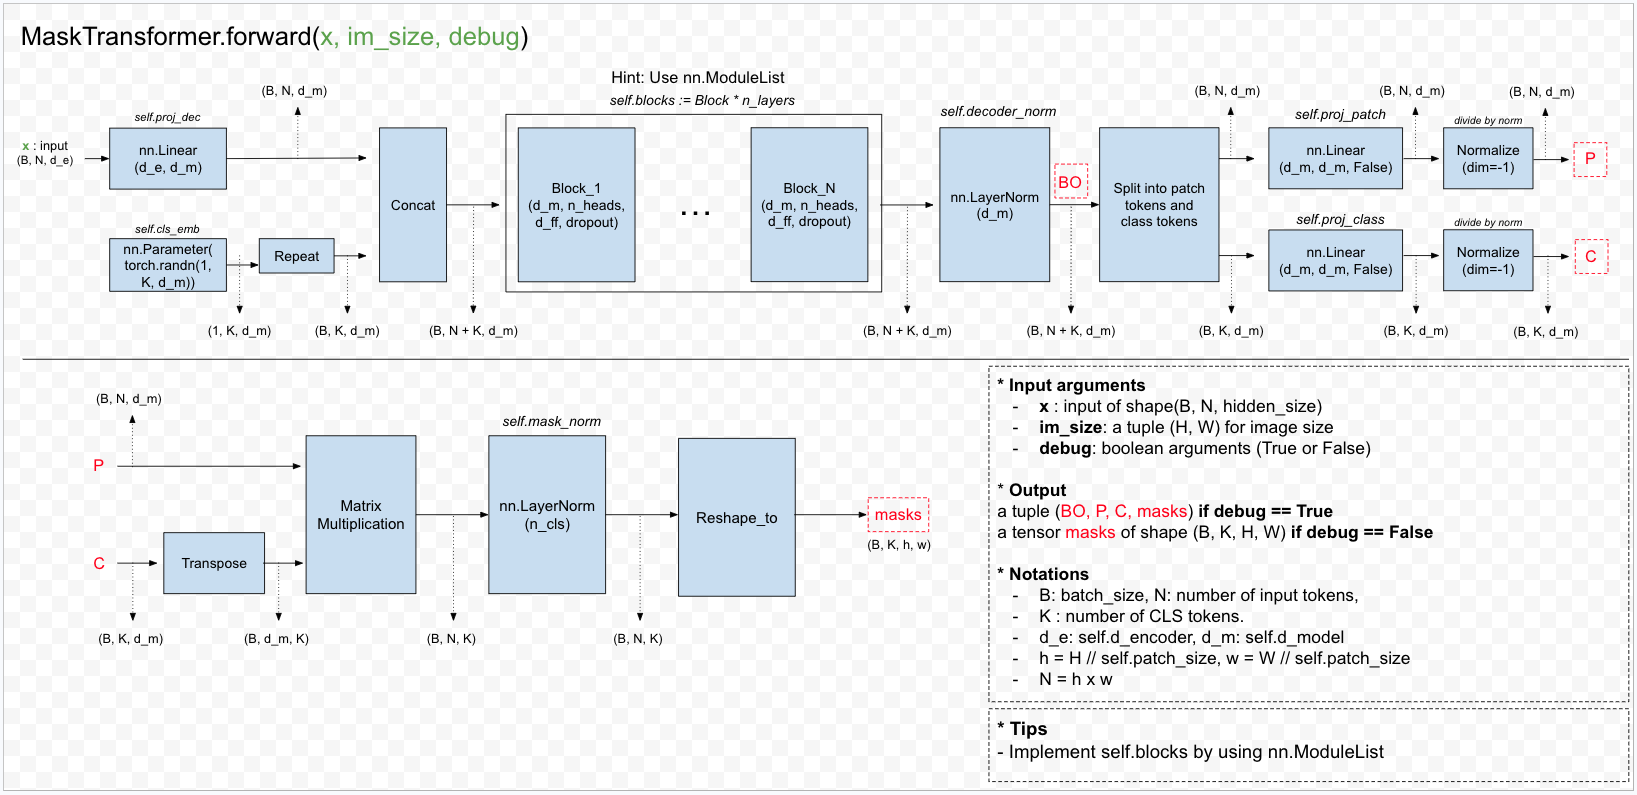

In [11]:
from timm.models.layers import trunc_normal_
class MaskTransformer(nn.Module):
    def __init__(
        self,
        n_cls=21,
        patch_size=16,
        d_encoder=192,
        n_layers=2,
        n_heads=3,
        d_model=192,
        dropout=0.1,
    ):
        super().__init__()
        self.d_encoder = d_encoder
        self.patch_size = patch_size
        self.n_layers = n_layers
        self.n_cls = n_cls
        self.d_model = d_model
        self.d_ff = d_ff = d_model * 4
        self.scale = d_model ** -0.5

        d_e = d_encoder
        d_m = d_model

        #######################################################################
        # Write your code here
        # def __init__(self, dim, heads, mlp_dim, dropout):
        self.blocks = nn.ModuleList([Block(d_m, n_heads, d_ff, dropout) for _ in range(n_layers)])
        self.cls_emb = nn.Parameter(torch.randn(1, n_cls, d_m))
        self.proj_dec = nn.Linear(in_features=d_e, out_features=d_m)
        self.proj_patch = nn.Linear(in_features=d_m, out_features=d_m, bias=False)
        self.proj_classes = nn.Linear(in_features=d_m, out_features=d_m, bias=False)
        self.decoder_norm = nn.LayerNorm(d_m)
        self.mask_norm = nn.LayerNorm(n_cls)
        #######################################################################

        self.apply(init_weights)
        self.proj_patch.weight.data = self.scale * torch.randn_like(self.proj_patch.weight.data)
        self.proj_classes.weight.data = self.scale * torch.randn_like(self.proj_classes.weight.data)
        trunc_normal_(self.cls_emb, std=0.02)

    def forward(self, x, im_size, debug=False):
        H, W = im_size
        GS = H // self.patch_size # grid_size       
        #####################################################
        # Write your code here
        # Add more lines as you wish.
        block_output = torch.cat((self.proj_dec(x), self.cls_emb.repeat(x.size(0), 1, 1)), dim=1)
        for block in self.blocks:
            block_output = block(block_output)
        block_output = self.decoder_norm(block_output)

        patches = self.proj_patch(block_output[:, :-self.n_cls, :])
        patches = patches / patches.norm(dim=-1, keepdim=True)

        cls_seg_feat = self.proj_classes(block_output[:, -self.n_cls:, :])
        cls_seg_feat = cls_seg_feat / cls_seg_feat.norm(dim=-1, keepdim=True)
       
        masks = self.mask_norm(patches @ cls_seg_feat.transpose(1, 2))
        # masks = rearrange(masks, "b (h w) n -> b n h w", h=int(GS)) # equivalent
        masks = masks.transpose(-2, -1).reshape(x.size(0), -1, GS, GS)
        #####################################################
        if debug:
          return block_output, patches, cls_seg_feat, masks
        
        return masks

    @torch.jit.ignore
    def no_weight_decay(self):
        return {"cls_emb"}


In [12]:
class DecoderLinear(nn.Module):
    def __init__(self, n_cls=21, patch_size=16, d_encoder=192):
        super().__init__()

        self.d_encoder = d_encoder
        self.patch_size = patch_size
        self.n_cls = n_cls

        self.head = nn.Linear(self.d_encoder, n_cls)
        self.apply(init_weights)

    @torch.jit.ignore
    def no_weight_decay(self):
        return set()

    def forward(self, x, im_size):
        H, W = im_size
        GS = H // self.patch_size
        x = self.head(x)
        x = rearrange(x, "b (h w) c -> b c h w", h=GS)

        return x

## MaskTransformer Tests

In [13]:
@torch.no_grad()
def run_tests_p2():
    n_pass, n_test = 0, 4
    B, N, C = 2, 16, 192
    im_size = (64, 64)
    try:
        torch.manual_seed(42)
        torch.cuda.manual_seed_all(42)
        net = MaskTransformer()
        print(f"[TEST  1/{n_test} Passed] MaskTransformer.__init__ executed without errors")
        n_pass += 1
    except Exception as e:
        print(f"[TEST  1/{n_test} Failed] MaskTransformer.__init__ execution error; please see the traceback below")
        print(f"\n{traceback.format_exc()}")
        return

    try:
        torch.manual_seed(42)
        torch.cuda.manual_seed_all(42)
        x = torch.randn(B, N, C)
        block_output, patches, cls_seg_feat, masks = net(x, im_size, debug=True)
        print(f"[TEST  2/{n_test} Passed] MaskTransformer.forward executed without errors")
        n_pass += 1

    except Exception as e:
        print(f"[TEST  2/{n_test} Failed] MaskTransformer.forward execution error;")
        print(f"\n{traceback.format_exc()}")
        return

    b_mean, b_std = block_output.abs().mean(), block_output.abs().std()
    p_mean, p_std = patches.abs().mean(), patches.abs().std()
    c_mean, c_std = cls_seg_feat.abs().mean(), cls_seg_feat.abs().std()
    m_mean, m_std = masks.abs().mean(), masks.abs().std()

    try:
        not_matches = []
        if block_output.shape != torch.Size([2, 37, 192]):
            not_matches.append('block_output')
        if patches.shape != torch.Size([2, 16, 192]):
            not_matches.append('patches')
        if cls_seg_feat.shape != torch.Size([2, 21, 192]):
            not_matches.append('cls_seg_feat')
        if masks.shape != torch.Size([2, 21, 4, 4]):
            not_matches.append('masks')
        assert len(not_matches) == 0
        print(f"[TEST  3/{n_test} Passed] Shape of outputs are matched")
        n_pass += 1
    except Exception as e:
        print(f"[TEST  3/{n_test} Failed] Shape of {not_matches} are not matched")

    try:
        not_matches = []
        if ((b_mean - 0.7917).abs() > 1e-4) or ((b_std - 0.6106).abs() > 1e-4):
            not_matches.append('q')
        if ((p_mean - 0.0576).abs() > 1e-4) or ((p_std - 0.0435).abs() > 1e-4):
            not_matches.append('k')
        if ((c_mean - 0.0577).abs() > 1e-4) or ((c_std - 0.0433).abs() > 1e-4):
            not_matches.append('cls_seg_feat')
        if ((m_mean - 0.8144).abs() > 1e-4) or ((m_std - 0.5783).abs() > 1e-4):
            not_matches.append('masks')
        assert len(not_matches) == 0
        print(f"[TEST  4/{n_test} Passed] All values are matched")
        n_pass += 1
    except Exception as e:
        print(f"[TEST  4/{n_test} Failed] Value of {not_matches} are not matched")

    if n_pass == n_test:
        print(f"\n[TEST] 🎉🎉🥳 All {n_pass}/{n_test} tests passed!")


run_tests_p2()

[TEST  1/4 Passed] MaskTransformer.__init__ executed without errors
[TEST  2/4 Passed] MaskTransformer.forward executed without errors
[TEST  3/4 Passed] Shape of outputs are matched
[TEST  4/4 Passed] All values are matched

[TEST] 🎉🎉🥳 All 4/4 tests passed!


# Part 3. Implement Segmenter [(Illustration)](https://docs.google.com/drawings/d/19914B8kWbAZrIwiFJBxkRESSN9_T5MRJ43YT6NL-SCg)

Segmenter class connects the ViT encoder with MaskTransformer (decoder).
Segmenter will get images shaped as (B, 3, H, W) and return the class logit map shaped as (B, num_cls, H, W).

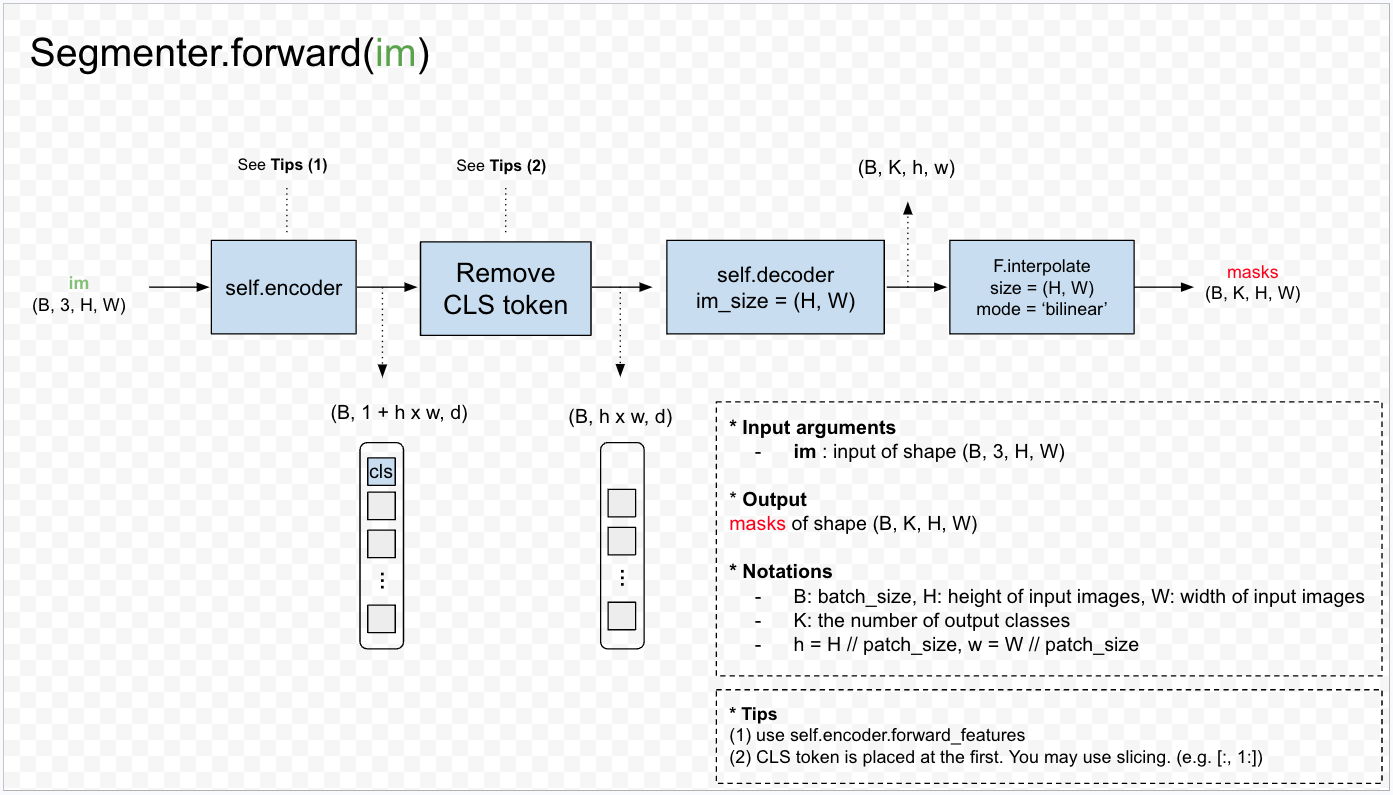

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from timm.models.layers import trunc_normal_

class Segmenter(nn.Module):
    def __init__(
        self,
        n_cls=21,
        use_tf=True,
    ):
        super().__init__()
        self.n_cls = n_cls
        encoder = vit_tiny_patch16_384(pretrained=True)
        decoder = MaskTransformer() if use_tf else DecoderLinear()
        self.patch_size = 16
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, im):
        H_ori, W_ori = im.size(2), im.size(3)
        H, W = im.size(2), im.size(3)
        ############################################################
        # Write your code here
        # Add more lines as you wish.
        masks = self.encoder.forward_features(im)[:, 1:]
        masks = self.decoder(masks, (H, W))
        masks = F.interpolate(masks, size=(H, W), mode="bilinear")
        ############################################################
        return masks

    @torch.jit.ignore
    def no_weight_decay(self):
        def append_prefix_no_weight_decay(prefix, module):
            return set(map(lambda x: prefix + x, module.no_weight_decay()))

        nwd_params = append_prefix_no_weight_decay("encoder.", self.encoder).union(
            append_prefix_no_weight_decay("decoder.", self.decoder)
        )
        return nwd_params

## Segmenter Tests

In [15]:
@torch.no_grad()
def run_tests_p3():
    n_pass, n_test = 0, 4
    try:
        torch.manual_seed(42)
        torch.cuda.manual_seed_all(42)
        net = Segmenter()
        print(f"[TEST  1/{n_test} Passed] Segmenter.__init__ executed without errors")
        n_pass += 1
    except Exception as e:
        print(f"[TEST  1/{n_test} Failed] Segmenter.__init__ execution error; please see the traceback below")
        print(f"\n{traceback.format_exc()}")
        return

    try:
        torch.manual_seed(42)
        torch.cuda.manual_seed_all(42)
        im = torch.randn(1, 3, im_size, im_size)
        masks = net(im)
        print(f"[TEST  2/{n_test} Passed] Segmenter.forward executed without errors")
        n_pass += 1

    except Exception as e:
        print(f"[TEST  2/{n_test} Failed] Segmenter.forward execution error;")
        print(f"\n{traceback.format_exc()}")
        return

    m_mean, m_std = masks.abs().mean(), masks.abs().std()
    try:
        assert masks.shape == torch.Size([1, 21, im_size, im_size])
        print(f"[TEST  3/{n_test} Passed] Shape of mask is matched")
        n_pass += 1
    except Exception as e:
        print(f"[TEST  3/{n_test} Failed] Shape of mask is not matched")

    try:
        assert ((m_mean - 0.7249).abs() <= 1e-4) and ((m_std - 0.4966).abs() <= 1e-4)
        print(f"[TEST  4/{n_test} Passed] Mask logits are matched")
        n_pass += 1
    except Exception as e:
        print(f"[TEST  4/{n_test} Failed] Mask logits are not matched")

    if n_pass == n_test:
        print(f"\n[TEST] 🎉🎉🥳 All {n_pass}/{n_test} tests passed!")

run_tests_p3()

[TEST  1/4 Passed] Segmenter.__init__ executed without errors
[TEST  2/4 Passed] Segmenter.forward executed without errors
[TEST  3/4 Passed] Shape of mask is matched
[TEST  4/4 Passed] Mask logits are matched

[TEST] 🎉🎉🥳 All 4/4 tests passed!


---
# Training function

## Training pipeline

### (a) Forward/Backward step for training
- Feed the image through the model.
- Perform a gradient step based on the loss. Loss can be calculated using `criterion`, located at the beginning of the function.
- Choose the highest logit per pixel as prediction.

### (b) Forward step for validation
- Feed the image through the model.
- Calculate loss on current image.
- Choose the highest logit per pixel as prediction.

In [21]:
import tqdm

def get_prediction(criterion, net, image, label):
    output = net(image)
    loss = criterion(output, label).mean()
    pred = torch.argmax(output, dim=1)
    return output, loss, pred

def train_net(net, resume=False):
    # 21 is the index for boundaries: therefore we ignore this index.
    criterion = nn.CrossEntropyLoss(ignore_index=21, reduction='none')
    colorize = Colorize(21, get_color_map())
    best_valid_iou = 0

    if resume:
        checkpoint = torch.load(ckpt_path)
        net.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        epoch = checkpoint['epoch']
        best_valid_iou = checkpoint['best_valid_iou']
        print(f'Resume training from epoch {epoch+1}')
    else:
        epoch = 0

    while epoch < args.epoch:
        t1 = time.time()
        saved_images, saved_labels = [], []

        # start training
        net.train()

        loss_total = 0
        ious = []
        pixel_accs = []

        for batch_idx, (image, label) in tqdm.tqdm(enumerate(train_loader)):
            # save images for visualization.
            if len(saved_images) < 4:
                saved_images.append(image.cpu())
                saved_labels.append(add_padding(label.cpu()))

            # move variables to gpu.
            image = image.to(device)
            label = label.to(device)

            output, loss, pred = get_prediction(criterion, net, image, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # update total loss.
            loss_total += loss.item()

            # target
            target = label.squeeze(1).cpu().numpy()

            # calculate pixel accuarcy and mean IoU
            acc, mean_iu = label_accuracy_score(target, pred.cpu().detach().numpy(), n_class=21)

            pixel_accs.append(acc)
            ious.append(mean_iu)

            if batch_idx % 1000 == 0:
                print(f'Epoch : {epoch} || {batch_idx}/{len(train_loader)} || loss : {loss.item():.3f}, iou : {mean_iu * 100:.3f} pixel_acc : {acc * 100:.3f}')

            if batch_idx % 50 == 0:
                writer.add_scalar('train_loss_step', loss.item(), batch_idx + epoch * len(train_loader))
                writer.add_scalar('pixel_acc_step', acc, batch_idx + epoch * len(train_loader))
                writer.add_scalar('mean_iou_step', mean_iu, batch_idx + epoch * len(train_loader))


        # calculate average IoU
        total_ious = np.array(ious).T
        total_ious = np.nanmean(total_ious).mean()
        total_pixel_acc = np.array(pixel_accs).mean()

        writer.add_scalar('train_loss', loss_total / len(train_loader), epoch)
        writer.add_scalar('pixel_acc', total_pixel_acc, epoch)
        writer.add_scalar('mean_iou', total_ious, epoch)

        # image visualization
        un_norms, preds, outputs = [], [], []
        for image, label in zip(saved_images, saved_labels):
            # denormalize the image.
            image_permuted = image.permute(1, 0, 2, 3)
            un_norm = torch.zeros_like(image_permuted)
            for idx, (im, m, s) in enumerate(zip(image_permuted, mean, std)):
                un_norm[idx] = (im * s) + m
            un_norm = un_norm.permute(1, 0, 2, 3)
            un_norms.append(add_padding(un_norm))

            with torch.no_grad():
                output = net(image.to(device))
                pred = torch.argmax(output, dim=1)
                preds.append(add_padding(pred))

        # stitch images into a grid.
        un_norm = make_grid(torch.cat(un_norms), nrow=2)
        label = make_grid(colorize(torch.stack(saved_labels)), nrow=2)
        pred = make_grid(colorize(torch.stack(preds)), nrow=2)

        # write images to Tensorboard.
        writer.add_image('img', un_norm, epoch)
        writer.add_image('gt', label, epoch)
        writer.add_image('pred', pred, epoch)

        t = time.time() - t1
        print(f'>> Epoch : {epoch} || AVG loss : {loss_total / len(train_loader):.3f}, iou : {total_ious * 100:.3f} pixel_acc : {total_pixel_acc * 100:.3f} {t:.3f} secs')

        # evaluation
        net.eval()
        saved_images, saved_labels = [], []

        valid_loss_total = 0
        valid_ious = []
        valid_pixel_accs = []

        with torch.no_grad():
            for batch_idx, (image, label) in tqdm.tqdm(enumerate(test_loader)):
                # save images for visualization.
                if len(saved_images) < 4:
                    saved_images.append(image.cpu())
                    saved_labels.append(add_padding(label.cpu()))

                # move variables to gpu.
                image = image.to(device)
                label = label.to(device)

                output, loss, pred = get_prediction(criterion, net, image, label)

                # update total loss.
                valid_loss_total += loss.item()

                output = output.data.cpu().numpy()
                target = label.squeeze(1).cpu().numpy()

                acc, mean_iu = label_accuracy_score(target, pred.cpu().numpy(), n_class=21)

                valid_pixel_accs.append(acc)
                valid_ious.append(mean_iu)

        # calculate average IoU
        total_valid_ious = np.array(valid_ious).T
        total_valid_ious = np.nanmean(total_valid_ious).mean()
        total_valid_pixel_acc = np.array(valid_pixel_accs).mean()

        writer.add_scalar('valid_train_loss', valid_loss_total / len(test_loader), epoch)
        writer.add_scalar('valid_pixel_acc', total_valid_pixel_acc, epoch)
        writer.add_scalar('valid_mean_iou', total_valid_ious, epoch)

        # image visualization + CRF
        un_norms, preds, pred_crfs, outputs = [], [], [], []
        for image, label in zip(saved_images, saved_labels):
            # denormalize the image.
            image_permuted = image.permute(1, 0, 2, 3)
            un_norm = torch.zeros_like(image_permuted)
            for idx, (im, m, s) in enumerate(zip(image_permuted, mean, std)):
                un_norm[idx] = (im * s) + m
            un_norm = un_norm.permute(1, 0, 2, 3)
            un_norms.append(add_padding(un_norm))

            with torch.no_grad():
                output = net(image.to(device))
                outputs.append(add_padding(output))
                pred = torch.argmax(output, dim=1)
                preds.append(add_padding(pred))

            # CRF
            output_softmax = torch.nn.functional.softmax(output, dim=1).detach().cpu()
            un_norm_int = (un_norm * 255).squeeze().permute(1, 2, 0).numpy().astype(np.ubyte)
            pred_crf = dense_crf(un_norm_int, output_softmax.squeeze().numpy())
            pred_crfs.append(add_padding(torch.argmax(torch.Tensor(pred_crf), dim=0)).unsqueeze(0))

        # stitch images into a grid.
        valid_un_norm = make_grid(torch.cat(un_norms), nrow=2)
        valid_label = make_grid(colorize(torch.stack(saved_labels)), nrow=2)
        valid_pred = make_grid(colorize(torch.stack(preds)), nrow=2)
        valid_pred_crf = make_grid(colorize(torch.stack(pred_crfs)), nrow=2)

        # write images to tensorboard.
        writer.add_image('valid_img', valid_un_norm, epoch)
        writer.add_image('valid_gt', valid_label, epoch)
        writer.add_image('valid_pred', valid_pred, epoch)
        writer.add_image('valid_pred_crf', valid_pred_crf, epoch)

        print(f'>> Epoch : {epoch} || AVG valid loss : {valid_loss_total / len(test_loader):.3f}, iou : {total_valid_ious * 100:.3f} pixel_acc : {total_valid_pixel_acc * 100:.3f} {t:.3f} secs')

        # save checkpoints every epoch.
        checkpoint = {
            'epoch': epoch + 1,
            'state_dict': net.state_dict(),
            'optimizer': optimizer.state_dict(),
            'best_valid_iou': best_valid_iou
        }
        torch.save(checkpoint, ckpt_path)

        # save best checkpoint.
        if total_valid_ious > best_valid_iou:
            best_valid_iou = total_valid_ious
            torch.save(net.state_dict(), ckpt_dir / 'best.pt')

        epoch += 1
    print(f'>> Best validation set iou: {best_valid_iou}')

---
# Train models through the pipeline

In this section, you will
- Create/load directory.
- Select which model to train.
- Create model and optimizer.

The training process will automatically save checkpoints to your Google drive after every epoch under `parent_dir`. Training could take up to 40 minutes per epoch. As we provide  pretrained weights to start with, you will only be training for 2 epochs on your own. Uncomment the lines after `# Select model here.` to choose which model to train.  
**You must load the provided pretrained weights**, otherwise achieving reasonable performance will take much longer.  
**If you would like to resume** from an existing `model.pt`, then
- Comment out the line below `Load pretrained weights here.`,
- Specify `parent_dir` as instructed,
- Run the first code cell again, then run `train_net` with `resume=True` parameter.  

<font color="red">Do not terminate your process right after an epoch has finished.</font> Writing the saved model back to Google drive will take an extra couple of minutes, and aborting in the middle will likely ruin your checkpoint file.

In [22]:
num_trial=0
result_dir= Path(root) / 'results'
parent_dir = result_dir / f'trial_{num_trial}'
while parent_dir.is_dir():
    num_trial = int(parent_dir.name.replace('trial_',''))
    parent_dir = result_dir / f'trial_{num_trial+1}'

# modify parent_dir here if you want to resume from a checkpoint, or to rename directory.
# parent_dir = result_dir / 'trial_99'
print(f'Logs and ckpts will be saved in : {parent_dir}')

log_dir = parent_dir
ckpt_dir = parent_dir
ckpt_path = parent_dir / 'model.pt'
writer = SummaryWriter(log_dir)

# select model here.
model = Segmenter(use_tf=True).cuda()
# model = Segmenter(use_tf=False).cuda()

# define optimizer.
params = list(model.parameters())
nwd_names = list(model.no_weight_decay())
wd_params = []
nwd_params = []
for n, p in model.named_parameters():
    ignore = False
    for ign in nwd_names:
        if n.startswith(ign):
            nwd_params.append(p)
            ignore=True
            continue
    if not ignore:
        wd_params.append(p)
optimizer = SGD([{'params': nwd_params, 'weight_decay': 0},
                 {'params': wd_params}],
                lr=args.lr, momentum=args.momentum, weight_decay=args.weight_decay)

Logs and ckpts will be saved in : results/trial_0


In [23]:
torch.use_deterministic_algorithms(False)
torch.backends.cudnn.deterministic = True
train_net(model, resume=False)

4it [00:00,  6.04it/s]

Epoch : 0 || 0/8498 || loss : 3.407, iou : 0.407 pixel_acc : 5.066


1006it [00:36, 28.61it/s]

Epoch : 0 || 1000/8498 || loss : 0.957, iou : 38.473 pixel_acc : 75.836


2005it [01:11, 28.15it/s]

Epoch : 0 || 2000/8498 || loss : 2.045, iou : 3.653 pixel_acc : 38.647


3004it [01:47, 27.94it/s]

Epoch : 0 || 3000/8498 || loss : 0.713, iou : 40.240 pixel_acc : 85.367


4006it [02:22, 28.28it/s]

Epoch : 0 || 4000/8498 || loss : 0.610, iou : 42.616 pixel_acc : 84.294


5005it [02:58, 28.35it/s]

Epoch : 0 || 5000/8498 || loss : 0.445, iou : 25.048 pixel_acc : 91.595


6004it [03:33, 28.34it/s]

Epoch : 0 || 6000/8498 || loss : 0.393, iou : 59.415 pixel_acc : 88.344


7006it [04:08, 28.43it/s]

Epoch : 0 || 7000/8498 || loss : 0.126, iou : 91.913 pixel_acc : 97.308


8005it [04:43, 28.30it/s]

Epoch : 0 || 8000/8498 || loss : 0.234, iou : 88.034 pixel_acc : 94.234


8498it [05:01, 28.20it/s]


>> Epoch : 0 || AVG loss : 0.561, iou : 47.828 pixel_acc : 85.841 301.787 secs


2857it [00:49, 58.14it/s]


>> Epoch : 0 || AVG valid loss : 0.367, iou : 61.252 pixel_acc : 89.576 301.787 secs


0it [00:00, ?it/s]

Epoch : 1 || 0/8498 || loss : 0.140, iou : 62.201 pixel_acc : 97.652


1005it [00:35, 28.15it/s]

Epoch : 1 || 1000/8498 || loss : 0.202, iou : 65.626 pixel_acc : 94.542


2004it [01:10, 28.42it/s]

Epoch : 1 || 2000/8498 || loss : 0.382, iou : 59.290 pixel_acc : 88.481


3006it [01:46, 28.05it/s]

Epoch : 1 || 3000/8498 || loss : 0.324, iou : 60.644 pixel_acc : 91.680


4005it [02:22, 27.38it/s]

Epoch : 1 || 4000/8498 || loss : 0.151, iou : 24.269 pixel_acc : 96.993


5004it [02:59, 25.79it/s]

Epoch : 1 || 5000/8498 || loss : 0.290, iou : 90.619 pixel_acc : 95.079


6006it [03:34, 28.35it/s]

Epoch : 1 || 6000/8498 || loss : 0.379, iou : 59.993 pixel_acc : 81.977


7004it [04:11, 28.17it/s]

Epoch : 1 || 7000/8498 || loss : 0.494, iou : 42.627 pixel_acc : 82.757


8006it [04:46, 28.34it/s]

Epoch : 1 || 8000/8498 || loss : 0.095, iou : 92.874 pixel_acc : 98.084


8498it [05:03, 27.96it/s]


>> Epoch : 1 || AVG loss : 0.323, iou : 63.971 pixel_acc : 90.876 304.319 secs


2857it [00:49, 58.15it/s]


>> Epoch : 1 || AVG valid loss : 0.320, iou : 63.977 pixel_acc : 90.412 304.319 secs


6it [00:00, 28.17it/s]

Epoch : 2 || 0/8498 || loss : 0.289, iou : 83.505 pixel_acc : 91.030


1005it [00:35, 28.38it/s]

Epoch : 2 || 1000/8498 || loss : 0.139, iou : 85.476 pixel_acc : 95.498


2004it [01:10, 28.59it/s]

Epoch : 2 || 2000/8498 || loss : 0.072, iou : 92.756 pixel_acc : 98.550


3006it [01:46, 28.28it/s]

Epoch : 2 || 3000/8498 || loss : 1.826, iou : 29.967 pixel_acc : 59.527


4005it [02:21, 28.31it/s]

Epoch : 2 || 4000/8498 || loss : 0.152, iou : 90.853 pixel_acc : 98.193


5004it [02:57, 28.07it/s]

Epoch : 2 || 5000/8498 || loss : 0.094, iou : 95.278 pixel_acc : 98.073


6006it [03:32, 28.15it/s]

Epoch : 2 || 6000/8498 || loss : 0.149, iou : 87.364 pixel_acc : 96.034


7005it [04:08, 28.30it/s]

Epoch : 2 || 7000/8498 || loss : 0.082, iou : 94.452 pixel_acc : 97.772


8004it [04:43, 28.27it/s]

Epoch : 2 || 8000/8498 || loss : 0.059, iou : 94.738 pixel_acc : 98.410


8498it [05:01, 28.19it/s]


>> Epoch : 2 || AVG loss : 0.254, iou : 68.742 pixel_acc : 92.493 301.905 secs


2857it [00:47, 59.76it/s]


>> Epoch : 2 || AVG valid loss : 0.302, iou : 65.583 pixel_acc : 90.675 301.905 secs


6it [00:00, 28.29it/s]

Epoch : 3 || 0/8498 || loss : 0.189, iou : 60.138 pixel_acc : 94.862


1005it [00:35, 28.38it/s]

Epoch : 3 || 1000/8498 || loss : 0.078, iou : 58.242 pixel_acc : 98.853


2004it [01:10, 28.57it/s]

Epoch : 3 || 2000/8498 || loss : 0.119, iou : 83.927 pixel_acc : 96.898


3006it [01:46, 28.29it/s]

Epoch : 3 || 3000/8498 || loss : 0.097, iou : 93.251 pixel_acc : 97.502


4005it [02:21, 28.47it/s]

Epoch : 3 || 4000/8498 || loss : 0.296, iou : 60.710 pixel_acc : 90.976


5004it [02:56, 28.52it/s]

Epoch : 3 || 5000/8498 || loss : 0.310, iou : 52.172 pixel_acc : 90.421


6006it [03:31, 28.47it/s]

Epoch : 3 || 6000/8498 || loss : 0.074, iou : 96.706 pixel_acc : 98.329


7005it [04:06, 28.22it/s]

Epoch : 3 || 7000/8498 || loss : 0.153, iou : 30.559 pixel_acc : 95.111


8004it [04:42, 28.40it/s]

Epoch : 3 || 8000/8498 || loss : 0.032, iou : 94.056 pixel_acc : 99.209


8498it [04:59, 28.33it/s]


>> Epoch : 3 || AVG loss : 0.217, iou : 71.380 pixel_acc : 93.445 300.347 secs


2857it [00:48, 58.56it/s]


>> Epoch : 3 || AVG valid loss : 0.292, iou : 67.235 pixel_acc : 91.145 300.347 secs


6it [00:00, 27.95it/s]

Epoch : 4 || 0/8498 || loss : 0.097, iou : 59.853 pixel_acc : 96.842


1005it [00:35, 27.92it/s]

Epoch : 4 || 1000/8498 || loss : 0.246, iou : 84.570 pixel_acc : 92.032


2004it [01:10, 28.29it/s]

Epoch : 4 || 2000/8498 || loss : 0.220, iou : 55.358 pixel_acc : 90.923


3006it [01:46, 28.01it/s]

Epoch : 4 || 3000/8498 || loss : 0.057, iou : 62.330 pixel_acc : 98.735


4005it [02:21, 27.94it/s]

Epoch : 4 || 4000/8498 || loss : 0.053, iou : 36.250 pixel_acc : 98.121


5004it [02:57, 27.75it/s]

Epoch : 4 || 5000/8498 || loss : 0.068, iou : 94.602 pixel_acc : 97.972


6006it [03:33, 28.19it/s]

Epoch : 4 || 6000/8498 || loss : 0.413, iou : 23.899 pixel_acc : 92.359


7005it [04:08, 28.30it/s]

Epoch : 4 || 7000/8498 || loss : 0.173, iou : 76.680 pixel_acc : 94.594


8004it [04:43, 28.35it/s]

Epoch : 4 || 8000/8498 || loss : 0.196, iou : 81.474 pixel_acc : 93.269


8498it [05:01, 28.19it/s]


>> Epoch : 4 || AVG loss : 0.189, iou : 73.651 pixel_acc : 94.162 301.825 secs


2857it [00:47, 59.66it/s]


>> Epoch : 4 || AVG valid loss : 0.289, iou : 66.870 pixel_acc : 91.092 301.825 secs


6it [00:00, 25.86it/s]

Epoch : 5 || 0/8498 || loss : 0.155, iou : 89.518 pixel_acc : 95.690


1005it [00:35, 28.13it/s]

Epoch : 5 || 1000/8498 || loss : 0.166, iou : 85.878 pixel_acc : 93.319


2004it [01:11, 28.46it/s]

Epoch : 5 || 2000/8498 || loss : 0.151, iou : 90.164 pixel_acc : 95.369


3006it [01:46, 28.27it/s]

Epoch : 5 || 3000/8498 || loss : 0.344, iou : 64.694 pixel_acc : 84.773


4005it [02:22, 28.40it/s]

Epoch : 5 || 4000/8498 || loss : 0.100, iou : 93.002 pixel_acc : 96.853


5004it [02:57, 27.97it/s]

Epoch : 5 || 5000/8498 || loss : 0.046, iou : 64.778 pixel_acc : 98.165


6006it [03:33, 27.39it/s]

Epoch : 5 || 6000/8498 || loss : 0.132, iou : 81.432 pixel_acc : 95.397


7005it [04:08, 28.15it/s]

Epoch : 5 || 7000/8498 || loss : 0.040, iou : 76.503 pixel_acc : 98.559


8004it [04:43, 28.16it/s]

Epoch : 5 || 8000/8498 || loss : 0.070, iou : 95.839 pixel_acc : 97.904


8498it [05:01, 28.17it/s]


>> Epoch : 5 || AVG loss : 0.172, iou : 75.019 pixel_acc : 94.594 302.037 secs


2857it [00:48, 59.38it/s]


>> Epoch : 5 || AVG valid loss : 0.294, iou : 67.718 pixel_acc : 91.210 302.037 secs
>> Best validation set iou: 0.6771759203501121


# Aggregating Results

After you've trained Segmenter, load your best models and run the following block to check validation accuracy, and compare IoU improvements made by CRF. Since the validation set contains nearly 3,000 images, this will take up to 30 minutes.

You can regard that your implementation is correct if performance is in ± 2%p (pixel accuracy), 0.01 (mIoU) of the following values:
- Segmenter(use_tf=True)
  - After Epoch 0
    - AVG valid iou : 60.29 pixel_acc : 89.83
  - After Epoch 1
    - AVG valid iou : 65.19 pixel_acc : 90.11

- Segmenter(use_tf=False)
  - After Epoch 0
    - AVG valid iou : 60.13 pixel_acc : 89.30
  - After Epoch 1
    - AVG valid iou : 62.21 pixel_acc : 90.51


The exact values are subject to change, don't worry too much if you missed the range by a small margin.

In [25]:
# specify path to your best trained model.
# for example if you want to load Segmenter from folder 'trial_5', modify 'trial_99' into 'trial_5'.
segmenter_path = result_dir / 'trial_0' / 'best.pt'

# OPTIONAL: Read text below this code cell.
use_crf = False

net = Segmenter().to(device)
net.load_state_dict(torch.load(segmenter_path, map_location=device))

criterion = nn.CrossEntropyLoss(ignore_index=21, reduction='none')
colorize = Colorize(21, get_color_map())

net.eval()

valid_loss_total = 0
valid_ious = []
valid_pixel_accs = []
valid_ious_crf = []
valid_pixel_accs_crf = []

with torch.no_grad():
    for batch_idx, (image, label) in enumerate(test_loader):
        # Move variables to gpu.
        image = image.to(device)
        label = label.to(device)

        output, loss, pred = get_prediction(criterion, net, image, label)
        # CRF for some images.
        if use_crf:
            image_permuted = image.cpu().permute(1, 0, 2, 3)
            un_norm = torch.zeros_like(image_permuted)
            for idx, (im, m, s) in enumerate(zip(image_permuted, mean, std)):
                un_norm[idx] = (im * s) + m
            un_norm = un_norm.permute(1, 0, 2, 3)

            output_softmax = torch.nn.functional.softmax(output, dim=1).detach().cpu()
            un_norm_int = (un_norm * 255).squeeze().permute(1, 2, 0).numpy().astype(np.ubyte)
            pred_crf = dense_crf(un_norm_int, output_softmax.squeeze().numpy())
            pred_crf = np.expand_dims(np.argmax(pred_crf, 0), 0)

            target = label.squeeze(1).cpu().numpy()
            acc_crf, mean_iu_crf = label_accuracy_score(target, pred_crf, n_class=21)
            valid_pixel_accs_crf.append(acc_crf)
            valid_ious_crf.append(mean_iu_crf)

        target = label.squeeze(1).cpu().numpy()
        acc, mean_iu = label_accuracy_score(target, pred.cpu().numpy(), n_class=21)

        # update total loss.
        valid_loss_total += loss.item()

        valid_pixel_accs.append(acc)
        valid_ious.append(mean_iu)

        # # this is only for testing
        # if batch_idx > 50:
        #   break

    # calculate average IoU
    total_valid_ious = np.array(valid_ious).T
    total_valid_ious = np.nanmean(total_valid_ious).mean()
    total_valid_pixel_acc = np.array(valid_pixel_accs).mean()

    print(f'{type(net).__name__}:')
    print(f'Pixel accuracy: {total_valid_pixel_acc * 100:.3f}, mIoU: {total_valid_ious:.3f}')

    if use_crf:
        total_valid_ious_crf = np.array(valid_ious_crf).T
        total_valid_ious_crf = np.nanmean(total_valid_ious_crf).mean()
        total_valid_pixel_acc_crf = np.array(valid_pixel_accs_crf).mean()
        print(f'CRF Pixel accuracy: {total_valid_pixel_acc_crf * 100:.3f}, CRF mIoU: {total_valid_ious_crf:.3f}')

/tmp/ipykernel_435392/4220241571.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(segmenter_path, map_location=device))


Segmenter:
Pixel accuracy: 91.210, mIoU: 0.677


**Optional**: One way to improve the semantic segmentation is to apply Conditional Randon Field (CRF) as post-processing. In a nutshell, CRF will constrain the labeling via penalizing different labels to similar pixels. Since the CRF works in the original image, some detailed structure information lost in the encoder can be reconstructed via this process.

You can practice the CRF by setting `use_crf=True` in the above code block. Feel free to try it and see how it refines the labels.